<H1>Are inhibitory connectivity motifs entirely random?</H1>
We will count the number of inhibitory connectivity motifs (electrical and chemical) and test whether this number is expected assuming an average connectivity found experimentally.

In [1]:
# loading python modules
import numpy as np
np.random.seed(0)

from matplotlib.pyplot import figure
from terminaltables import AsciiTable 
import matplotlib.pyplot as plt
%matplotlib inline  

from __future__ import division

In [2]:
# loading custom inet modules
from inet import DataLoader, __version__
from inet.motifs import iicounter, motifcounter
from inet.utils import chem_squarematrix, elec_squarematrix
print('Inet version {}'.format(__version__))

Inet version 0.0.12


In [3]:
# use the dataset to create the null hypothesis
mydataset = DataLoader('../data/PV')

 190 syn  files loaded


<H2>Collect number of experiments containing PV(+) cells</H2>

In [4]:
# e.g. mydataset.PV[2].values  will return the different configurations with 2 PV cells
nPV = range(9)
for i in nPV:
    nPV[i] = np.sum(mydataset.IN[i].values())

In [5]:
for i, experiment in enumerate(nPV):
    print('{:<3d} recordings with {:2d} PV-cells'.format(experiment, i))

0   recordings with  0 PV-cells
151 recordings with  1 PV-cells
31  recordings with  2 PV-cells
8   recordings with  3 PV-cells
0   recordings with  4 PV-cells
0   recordings with  5 PV-cells
0   recordings with  6 PV-cells
0   recordings with  7 PV-cells
0   recordings with  8 PV-cells


In [6]:
# for the moment, we only count experiments with 2 or 3 PVs
# later we use mydataset.PV[2:]
PV2 = sum(mydataset.IN[2].values())
PV3 = sum(mydataset.IN[3].values())
PV2, PV3

(31, 8)

<H2> Calculate empirical probabilities </H2>

In [7]:
PC = mydataset.motif.ii_chem_found/mydataset.motif.ii_chem_tested
PE = mydataset.motif.ii_elec_found/mydataset.motif.ii_elec_tested

PC2  = mydataset.motif.ii_c2_found/mydataset.motif.ii_c2_tested
Pdiv = mydataset.motif.ii_div_found/mydataset.motif.ii_div_tested
Pcon = mydataset.motif.ii_con_found/mydataset.motif.ii_con_tested
Pchain = mydataset.motif.ii_chain_found/mydataset.motif.ii_chain_tested

PC1E = mydataset.motif.ii_c1e_found/mydataset.motif.ii_c1e_tested
PC2E = mydataset.motif.ii_c2e_found/mydataset.motif.ii_c2e_tested



info = [
    ['key', 'Probability', 'Motif', 'Value'],
    ['ii_chem', 'P(C)', 'chemical synapse',PC ],
    ['ii_elec', 'P(E)', 'electrical synapse',PE ],
    ['','',''],
    ['ii_c2', 'P(C U C)','bidirectional chemical synapse',PC2],
    ['ii_con', 'Pcon', 'convergent inhibitory motifs', Pcon],
    ['ii_div', 'Pdiv', 'divergent inhibitory motifs', Pdiv],
    ['ii_chain', 'Pchain', 'linear inhibitory motifs', Pchain],
    ['',''],
    ['ii_c1e', 'P(C U E)', 'electrical and unidirectional chemical', PC1E],
    ['ii_c2e', 'P(2C U E):','electrical and bidirectional chemical', PC2E],

]
print(AsciiTable(info).table)

+----------+-------------+----------------------------------------+-----------------+
| key      | Probability | Motif                                  | Value           |
+----------+-------------+----------------------------------------+-----------------+
| ii_chem  | P(C)        | chemical synapse                       | 0.281818181818  |
| ii_elec  | P(E)        | electrical synapse                     | 0.436363636364  |
|          |             |                                        |                 |
| ii_c2    | P(C U C)    | bidirectional chemical synapse         | 0.163636363636  |
| ii_con   | Pcon        | convergent inhibitory motifs           | 0.0416666666667 |
| ii_div   | Pdiv        | divergent inhibitory motifs            | 0.0833333333333 |
| ii_chain | Pchain      | linear inhibitory motifs               | 0.0833333333333 |
|          |             |                                        |                 |
| ii_c1e   | P(C U E)    | electrical and unidirection

<H2> Simulate random chemical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.


In [8]:
def mychem_simulation():
    """
    simulate inhibitory chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(chem_squarematrix(size=2,prob = PC))

    for _ in range(PV3):
        mycount += iicounter(chem_squarematrix(size=3, prob = PC))
        
    return(mycount)

In [9]:
print(mychem_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 110    |
| ii_c2    | 6     | 55     |
| ii_c2e   | 0     | 55     |
| ii_chain | 7     | 24     |
| ii_chem  | 34    | 110    |
| ii_con   | 3     | 24     |
| ii_div   | 0     | 24     |
| ii_elec  | 0     | 55     |
+----------+-------+--------+



In [10]:
# must contain the same number of tested connections
for key in mychem_simulation().keys():
    print(key, mydataset.motif[key])


('ii_chem', {'tested': 110L, 'found': 31})
('ii_c1e', {'tested': 110L, 'found': 18})
('ii_div', {'tested': 24L, 'found': 2})
('ii_c2e', {'tested': 55L, 'found': 6})
('ii_elec', {'tested': 55L, 'found': 24})
('ii_chain', {'tested': 24L, 'found': 2})
('ii_con', {'tested': 24L, 'found': 1})
('ii_c2', {'tested': 55L, 'found': 9})


In [11]:
# simulate the whole data set 1,000 times
n_chem = list()

n_bichem = list()
n_div = list()
n_con = list()
n_chain = list()

for _ in range(1000):
    syn_counter = mychem_simulation()
    n_chem.append(syn_counter['ii_chem']['found']) # null hypothesis
    
    n_bichem.append(syn_counter['ii_c2']['found'])    
    n_con.append(syn_counter['ii_con']['found'])
    n_div.append(syn_counter['ii_div']['found'])
    n_chain.append(syn_counter['ii_chain']['found'])

If the null hypothesis is correctly implemented, we should see almost the same 
number of chemical synases as in the experiments.

In [12]:
np.mean(n_chem) # on average the same number of unidirectional connections


31.053000000000001

In [13]:
mydataset.motif['ii_chem']['found']

31

If we found a number which is different form the empirical, we must revise our 
null hypothese.

In [14]:
np.mean(n_bichem) # on average the same number of bidirectional connections????

4.3490000000000002

Define analiticaly the null hypothese:

In [15]:
PC*PC*mydataset.motif['ii_c2']['tested'] # null hypothesis

4.368181818181818

In [16]:
mydataset.motif['ii_c2']['found'] # however, we found more empirically

9

In [17]:
# Number of divergent connections found should be very similar to the ones calculates
np.mean(n_div)

1.9419999999999999

In [18]:
PC*PC*mydataset.motif['ii_div']['tested'] # null hypothesis

1.9061157024793387

In [19]:
np.mean(n_con)

1.893

In [20]:
PC*PC*mydataset.motif['ii_con']['tested'] # null hypothesis

1.9061157024793387

<H2> Simulate random electrical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.

In [21]:
def myelec_simulation():
    """
    simulate inhibitory electrical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(elec_squarematrix(size=2,prob = PE))

    for _ in range(PV3):
        mycount += iicounter(elec_squarematrix(size=3, prob = PE))
        
    return(mycount)

In [22]:
print(myelec_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 110    |
| ii_c2    | 0     | 55     |
| ii_c2e   | 0     | 55     |
| ii_chain | 0     | 24     |
| ii_chem  | 0     | 110    |
| ii_con   | 0     | 24     |
| ii_div   | 0     | 24     |
| ii_elec  | 26    | 55     |
+----------+-------+--------+



In [23]:
# must contain the same number of tested connections
for key in myelec_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 110L, 'found': 31})
('ii_c1e', {'tested': 110L, 'found': 18})
('ii_div', {'tested': 24L, 'found': 2})
('ii_c2e', {'tested': 55L, 'found': 6})
('ii_elec', {'tested': 55L, 'found': 24})
('ii_chain', {'tested': 24L, 'found': 2})
('ii_con', {'tested': 24L, 'found': 1})
('ii_c2', {'tested': 55L, 'found': 9})


In [24]:
n_elec = list()
for _ in range(1000):
    syn_elec = myelec_simulation()
    n_elec.append(syn_elec['ii_elec']['found'])

Similarly, we must see almost the same 
number of electrical connections as with the experiments

In [25]:
np.mean(n_elec)

23.975000000000001

In [26]:
mydataset.motif.ii_elec_found # voila!

24

<H2>Simulate electrical and chemical synapses independently</H2>

In [27]:
C = chem_squarematrix(size = 2, prob = PC)
E = elec_squarematrix(size = 2, prob = PE)
C + E # when a chemical (1) and electrical (2) synapse add , they have the motif 3

array([[0, 0],
       [0, 0]])

In [28]:
def myii_simulation():
    """
    simulate inhibitory electrical and chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        C = chem_squarematrix(size = 2, prob = PC)
        E = elec_squarematrix(size = 2, prob = PE)
        
        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    for _ in range(PV3):
        C = chem_squarematrix(size = 3, prob = PC)
        E = elec_squarematrix(size = 3, prob = PE)

        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    return(mycount)

In [29]:
myii_simulation()# one simulation, again, test the number of connections tested

{'ii_c1e': {'found': 11, 'tested': 110L},
 'ii_c2': {'found': 4, 'tested': 55L},
 'ii_c2e': {'found': 1, 'tested': 55L},
 'ii_chain': {'found': 2, 'tested': 24L},
 'ii_chem': {'found': 27, 'tested': 110L},
 'ii_con': {'found': 2, 'tested': 24L},
 'ii_div': {'found': 2, 'tested': 24L},
 'ii_elec': {'found': 23, 'tested': 55L}}

In [30]:
# must contain the same number of tested connections
for key in myii_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 110L, 'found': 31})
('ii_c1e', {'tested': 110L, 'found': 18})
('ii_div', {'tested': 24L, 'found': 2})
('ii_c2e', {'tested': 55L, 'found': 6})
('ii_elec', {'tested': 55L, 'found': 24})
('ii_chain', {'tested': 24L, 'found': 2})
('ii_con', {'tested': 24L, 'found': 1})
('ii_c2', {'tested': 55L, 'found': 9})


In [31]:
# simulate the whole data set 1,000 times
n_chem = list()
n_elec = list()

n_c1e = list()
n_c2e = list()

n_c2 = list()
n_div = list()
n_con = list()
n_chain = list()

for _ in range(10000):
    syn_counter = myii_simulation()
    n_chem.append( syn_counter['ii_chem']['found'] ) # null hypothesis
    n_elec.append( syn_counter['ii_elec']['found'] ) # null hypothesis
    
    n_c1e.append( syn_counter['ii_c1e']['found'] )
    n_c2e.append( syn_counter['ii_c2e']['found'] )
    
    n_c2.append( syn_counter['ii_c2']['found'])
    n_con.append( syn_counter['ii_div']['found'])
    n_div.append( syn_counter['ii_div']['found'])
    n_chain.append( syn_counter['ii_chain']['found'])

In [32]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found']],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found']],
    [''],
    ['2 chem',np.mean(n_c2),mydataset.motif['ii_c2']['found']],
    ['convergent', np.mean(n_con), mydataset.motif['ii_con']['found']],
    ['divergent', np.mean(n_div), mydataset.motif['ii_div']['found']],
    ['chains', np.mean(n_chain), mydataset.motif['ii_chain']['found']],
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif['ii_c1e']['found']],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif['ii_c2e']['found']],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+
| Syn Motif     | Simulations | Empirical |
+---------------+-------------+-----------+
| chemical      | 30.9282     | 31        |
| electrical    | 23.9703     | 24        |
|               |             |           |
| 2 chem        | 4.3579      | 9         |
| convergent    | 1.8942      | 1         |
| divergent     | 1.8942      | 2         |
| chains        | 3.8094      | 2         |
|               |             |           |
| 1 chem + elec | 13.5081     | 18        |
| 2 chem + elec | 1.9215      | 6         |
+---------------+-------------+-----------+


Let's see if the connections found correspond to the theoretical values for the complex motifs. 


<H3>A) Unidirectional chemical connections in the presence of an electrical synapse *ii_c1e*</H3>

In [33]:
mydataset.motif['ii_c1e']

{'found': 18, 'tested': 110L}

In [34]:
PCE1 = mydataset.motif.ii_c1e_found /mydataset.motif.ii_c1e_tested
PCE1

0.16363636363636364

In [35]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PC*PE)*mydataset.motif.ii_c1e_tested 

13.527272727272726

<H3>B) Bidirectional chemical connections in the presence of one electrical synapse *ii_c2e*</H3>

In [36]:
mydataset.motif['ii_c2e']

{'found': 6, 'tested': 55L}

In [37]:
PCE2 = mydataset.motif.ii_c2e_found /mydataset.motif.ii_c2e_tested
PCE2

0.10909090909090909

In [38]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PE*PC*PC)*mydataset.motif.ii_c2e_tested #

1.9061157024793383

<H3>C) Only electrical synapses *ii_elec*</H3>

In [39]:
mydataset.motif['ii_elec']

{'found': 24, 'tested': 55L}

In [40]:
PE = mydataset.motif.ii_elec_found /mydataset.motif.ii_elec_tested
PE

0.43636363636363634

In [41]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PE)*mydataset.motif.ii_elec_tested #

24.0

<H3>D) Unidirectionaly chemmical only *ii_chem*</H3>


In [42]:
mydataset.motif['ii_chem']

{'found': 31, 'tested': 110L}

In [43]:
PC = mydataset.motif.ii_chem_found /mydataset.motif.ii_chem_tested
PC

0.2818181818181818

In [44]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PC)*mydataset.motif.ii_chem_tested #

30.999999999999996

<H3>E) Bidirectional chemical connections only *ii_c2*</H3>

In [45]:
mydataset.motif['ii_c2']

{'found': 9, 'tested': 55L}

In [46]:
PC1 = mydataset.motif.ii_chem_found /mydataset.motif.ii_chem_tested
PC1

0.2818181818181818

In [47]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PC1*PC1)*mydataset.motif.ii_c2_tested 

4.368181818181818

In [48]:
# calculate alfa_levels according to Zhao et al., 2001
alpha_rec = (PC1/(PC*PC))-1
print(alpha_rec)

2.54838709677


<H3>F) Divergent inhibitory connections *ii_div*</H3>

In [49]:
mydataset.motif['ii_div']

{'found': 2, 'tested': 24L}

In [50]:
Pdiv = mydataset.motif.ii_div_found /mydataset.motif.ii_div_tested
Pdiv

0.08333333333333333

In [51]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PC*PC)*mydataset.motif.ii_div_tested 

1.9061157024793387

In [52]:
# calculate alfa_levels according to Zhao et al., 2001
alpha_div = (Pdiv/(PC*PC))-1
print(alpha_div)

0.0492542490461


<H3>G) Convergent inhibitory connections *ii_con*</H3>

In [53]:
mydataset.motif['ii_con']

{'found': 1, 'tested': 24L}

In [54]:
Pcon = mydataset.motif.ii_con_found / mydataset.motif.ii_con_tested
Pcon

0.041666666666666664

In [55]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PC*PC)*mydataset.motif.ii_con_tested 

1.9061157024793387

In [56]:
# calculate alfa_levels according to Zhao et al., 2001
alpha_con = (Pcon/(PC*PC))-1
print(alpha_con)

-0.475372875477


<H3>H) Chain inhibitory connection *ii_chain* </H3>

In [57]:
mydataset.motif['ii_chain']

{'found': 2, 'tested': 24L}

In [58]:
Pchain = mydataset.motif.ii_chain_found / mydataset.motif.ii_chain_tested
Pchain

0.08333333333333333

In [59]:
# definition of the null hypothese
# if this value is close to the simulation, we accept the null hypothese
(PC*PC)*mydataset.motif.ii_chain_tested 

1.9061157024793387

In [60]:
# calculate alfa_levels according to Zhao et al., 2001
alpha_chain = (Pchain/(PC*PC))-1
print(alpha_chain)

0.0492542490461


<H2>Calculating P-Values</H2>

In [61]:
# operate with NumPY arrays rather than with lists
n_chem = np.array(n_chem)
n_elec = np.array(n_elec)


n_c2 = np.array(n_c2)
n_con = np.array(n_con)
n_div = np.array(n_div)
n_chain = np.array(n_chain)

n_c1e = np.array(n_c1e)
n_c2e = np.array(n_c2e)

In [62]:
pii_chem = len(n_chem[n_chem>mydataset.motif.ii_chem_found]) / n_chem.size
pii_elec = len(n_elec[n_elec>mydataset.motif.ii_elec_found])/ n_elec.size



pii_c2 =  len(n_c2[n_c2 > mydataset.motif.ii_c2_found])/ n_c2.size
pii_con = len(n_con[n_con < mydataset.motif.ii_con_found])/n_con.size # under-rep
pii_div = len(n_div[n_div > mydataset.motif.ii_div_found])/n_div.size
pii_chain = len(n_chain[n_chain < mydataset.motif.ii_chain_found])/n_chain.size # under-rep

pii_c1e = len(n_c1e[n_c1e > mydataset.motif.ii_c1e_found])/ n_c1e.size
pii_c2e = len(n_c2e[n_c2e > mydataset.motif.ii_c2e_found])/ n_c2e.size

In [63]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical', 'P(Simulations)', 'alpha'], 
    ['chemical', np.mean(n_chem),  mydataset.motif.ii_chem_found, pii_chem],
    ['electrical', np.mean(n_elec),  mydataset.motif.ii_elec_found, pii_elec],
    [''],
    ['2 chem bidirect', np.mean(n_c2),  mydataset.motif.ii_c2_found, pii_c2,alpha_rec],
    ['convergent', np.mean(n_con),  mydataset.motif.ii_con_found, pii_con, alpha_con],    
    ['divergent', np.mean(n_div), mydataset.motif.ii_div_found, pii_div, alpha_div],
    ['chain', np.mean(n_chain), mydataset.motif.ii_chain_found, pii_chain, alpha_chain],    
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif.ii_c1e_found, pii_c1e],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif.ii_c2e_found, pii_c2e],
     ]
print(AsciiTable(info).table)

+-----------------+-------------+-----------+----------------+-----------------+
| Syn Motif       | Simulations | Empirical | P(Simulations) | alpha           |
+-----------------+-------------+-----------+----------------+-----------------+
| chemical        | 30.9282     | 31        | 0.4439         |                 |
| electrical      | 23.9703     | 24        | 0.4385         |                 |
|                 |             |           |                |                 |
| 2 chem bidirect | 4.3579      | 9         | 0.0098         | 2.54838709677   |
| convergent      | 1.8942      | 1         | 0.1405         | -0.475372875477 |
| divergent       | 1.8942      | 2         | 0.2963         | 0.0492542490461 |
| chain           | 3.8094      | 2         | 0.1397         | 0.0492542490461 |
|                 |             |           |                |                 |
| 1 chem + elec   | 13.5081     | 18        | 0.0924         |                 |
| 2 chem + elec   | 1.9215  

In [64]:
from inet.plots import barplot

<H2> Plot chemical synapses alone</H2>

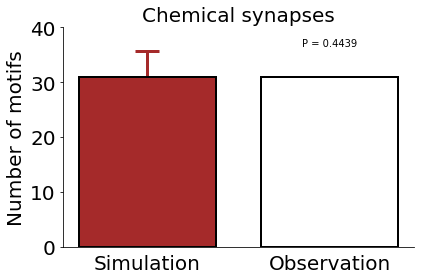

In [66]:
# This is our null hypothesis
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chem, n_found = mydataset.motif.ii_chem_found, larger=1);
ax.set_title('Chemical synapses', size=20);
ax.set_ylim(ymax=40);
ax.tick_params(labelsize=20)

fig.savefig('ii_chem.pdf')

<H2>Plot electrical synapses alone </H2>

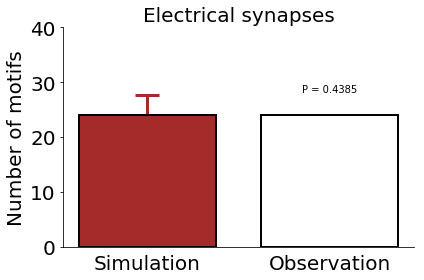

In [67]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_elec, n_found = mydataset.motif.ii_elec_found, larger=1);
ax.set_title('Electrical synapses',  size=20);
ax.set_ylim(ymax=40);
ax.tick_params(labelsize=20)

fig.savefig('ii_elec.pdf')

<H2>Plot bidirectional chemical synapses</H2>


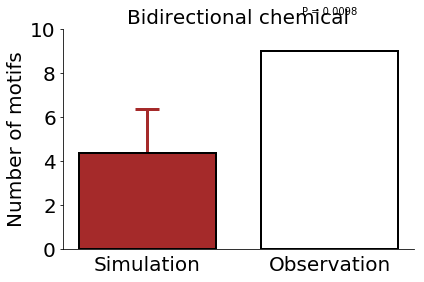

In [68]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2, n_found = mydataset.motif.ii_c2_found, larger=1);
ax.set_title('Bidirectional chemical',  size=20);
ax.set_ylim(ymax=10);
ax.tick_params(labelsize=20)

fig.savefig('ii_c2.pdf')

<H2>Plot convergent inhibitory</H2>

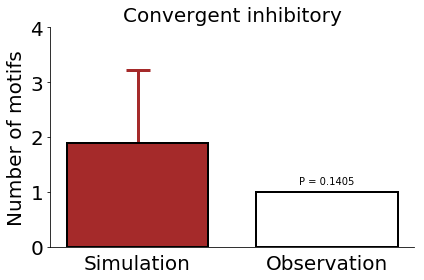

In [69]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_con, n_found = mydataset.motif.ii_con_found, larger=False);
ax.set_title('Convergent inhibitory',  size=20);
ax.set_ylim(ymin=0, ymax=4);
ax.tick_params(labelsize=20)

fig.savefig('ii_con.pdf')

<H2> Plot divergent inhibitory </H2>

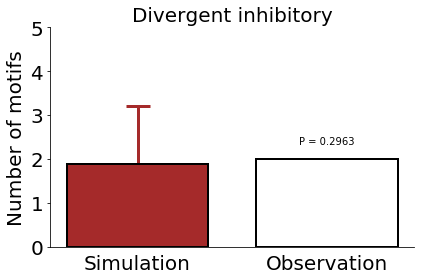

In [70]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_div, n_found = mydataset.motif.ii_div_found, larger=1);
ax.set_title('Divergent inhibitory',  size=20);
ax.set_ylim(ymin=0, ymax=5);
ax.tick_params(labelsize=20)

fig.savefig('ii_div.pdf')

<H2>Plot linear chains</H2>

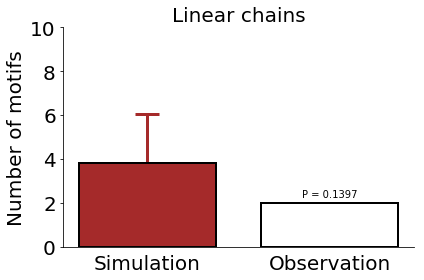

In [71]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chain, n_found = mydataset.motif.ii_chain_found, larger=False);
ax.set_title('Linear chains',  size=20);
ax.set_ylim(ymin=0, ymax=10);
ax.tick_params(labelsize=20)

fig.savefig('ii_chain.pdf')

#pii_chain # change this value in the plot!

<H2>Plot electrical and one chemical synapse alone </H2>

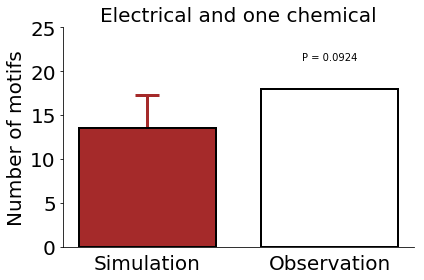

In [72]:
fig = figure() 
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c1e, n_found = mydataset.motif.ii_c1e_found, larger=1);
ax.set_title('Electrical and one chemical',  size=20);
ax.set_ylim(ymax=25);
ax.tick_params(labelsize=20)

fig.savefig('ii_c1e.pdf')

<H2>Plot electrical and two chemical</H2>

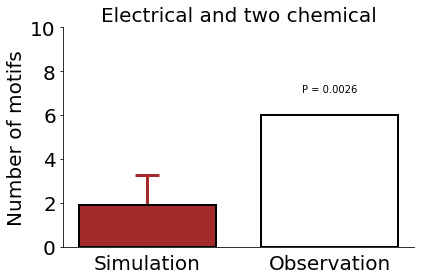

In [73]:
fig = figure(5)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2e, n_found = mydataset.motif.ii_c2e_found, larger=1);
ax.set_title('Electrical and two chemical',  size=20);
ax.set_ylim(ymin  = 0, ymax=10);
ax.tick_params(labelsize=20)

fig.savefig('ii_c2d.pdf')